In [15]:
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy.signal as ss
from numpy import linalg as LA

teta = [-10,40] #degrees #TODO test set
D = len(teta)
M1 = 10
M2 = 15
thresh_real = 0
thresh_im = 0

def Matrix(M, teta):
    D = len(teta)
    teta = np.radians(teta)
    A = np.zeros((M, D), dtype=complex)
    for j in range(D):
        A[:, j] = np.exp(-1j * np.pi*np.arange(M)*np.sin(teta[j]))
    return A
A1 = Matrix(M1, teta)
A2 = Matrix(M2, teta)

In [25]:
def observ1(SNR,snap):
    global A1
    real_s = np.random.normal(0, 1/math.sqrt(2),(D,snap))
    im_s = np.random.normal(0, 1/math.sqrt(2),(D,snap))
    s = real_s + 1j*im_s
    s_samp = s.reshape(D,snap)

    real_n = np.random.normal(0, (10**(-SNR/20))/math.sqrt(2),(M1,snap))
    im_n = np.random.normal(0, (10**(-SNR/20))/math.sqrt(2),(M1,snap))
    n = real_n + 1j*im_n
    n_samp = n.reshape(M1,snap)
    x_a_samp = (A1@s_samp)+n_samp
    return x_a_samp

def observ2(SNR,snap):
    global A2
    real_s = np.random.normal(0, 1/math.sqrt(2),(D,snap))
    im_s = np.random.normal(0, 1/math.sqrt(2),(D,snap))
    s = real_s + 1j*im_s
    s_samp = s.reshape(D,snap)

    real_n = np.random.normal(0, (10**(-SNR/20))/math.sqrt(2),(M2,snap))
    im_n = np.random.normal(0, (10**(-SNR/20))/math.sqrt(2),(M2,snap))
    n = real_n + 1j*im_n
    n_samp = n.reshape(M2,snap)
    x_a_samp = (A2@s_samp)+n_samp
    return x_a_samp

def quantize(A):
        return (1/math.sqrt(2))*(np.sign(A.real-(thresh_real))+(1j*(np.sign(A.imag-((thresh_im))))))

def quantize_part(A,P):
        mask = np.zeros(np.shape(A),dtype=complex)
        mask[:P,:] = (1/math.sqrt(2))*(np.sign(A[:P,:].real-(thresh_real))+(1j*(np.sign(A[:P,:].imag-((thresh_im))))))
        mask[P:,:] = A[P:,:]
        return mask

def covariance(v1,v2):
    normv1 = np.mean(v1,1)
    normv2 = np.mean(v2,1)
    v = v1-normv1.reshape(np.shape(v1)[0],1)
    u = v2 -normv2.reshape(np.shape(v2)[0],1)
    result = [v[:,i].reshape(np.shape(v)[0], 1)@u[:,i].conjugate().transpose().reshape(1, np.shape(u)[0]) for i in range(np.shape(v)[1])]
    return np.sum(result,0)/(np.shape(v)[1]-1)

In [20]:
def music_algorithm1(SNR,snapshot,monte,method=0,p=0):
    global D, M1
    error_vec = np.zeros(monte)
    theta_range = np.arange(-90, 91, 1)
    theta_range = np.radians(theta_range)  # Convert angles to radians
    num_angles = len(theta_range)
    rho = D*(10**(-SNR/10)+1)

    for i in range(monte):
        my_vec = observ1(SNR,snapshot)
        if method ==0:
            R = covariance(my_vec,my_vec)

        elif method ==1: #quantized
            R = quantize(covariance(my_vec,my_vec))

        elif method ==2: #quantized_sim
            R = quantize(covariance(my_vec,my_vec))
            R = rho*(np.sin((math.pi/2)*R.real)+1j*np.sin((math.pi/2)*R.imag))

        elif method ==3: #quantized_lin
            R = quantize(covariance(my_vec,my_vec))
            R = (rho*math.pi/2)*(np.subtract(R,1-(2/math.pi)*np.identity(M1)))
        else: #partial
            R = quantize_part(covariance(my_vec,my_vec),p)
            R[:p,:] = rho*(np.sin((math.pi/2)*R[:p,:].real)+1j*np.sin((math.pi/2)*R[:p,:].imag))

        eigvals, eigvecs = np.linalg.eig(R)
        sorted_indices = np.argsort(eigvals.real)[::-1]  # Sort eigenvalues in descending order
        eigvecs_sorted = eigvecs[:, sorted_indices]
        En = eigvecs_sorted[:, D:]

        music_spectrum = np.zeros(num_angles)
        for idx, theta in enumerate(theta_range):
            steering_vector = np.exp(-1j * np.pi * np.arange(M1) * np.sin(theta)) #TODO- out of the loop
            music_spectrum[idx] = 1 / np.linalg.norm(En.conj().T @ steering_vector)

        peaks, _ = ss.find_peaks(music_spectrum)
        peaks = list(peaks)
        peaks.sort(key=lambda x:music_spectrum[x])
        teta_vector = np.array(peaks[-D:])
        teta_vector = np.subtract(np.sort(teta_vector),90)
        error_vec[i] = (LA.norm((np.array(teta)-teta_vector))**2)
    return  [music_spectrum,theta_range,teta_vector,(((1/(monte*D))*np.sum(error_vec,0))**0.5)] #TODO modulo

def music_algorithm2(SNR,snapshot,monte,method=0,p=0):
    global D, M2
    error_vec = np.zeros(monte)
    theta_range = np.arange(-90, 91, 1)
    theta_range = np.radians(theta_range)  # Convert angles to radians
    num_angles = len(theta_range)
    rho = D*(10**(-SNR/10)+1)

    for i in range(monte):
        my_vec = observ2(SNR,snapshot)
        if method ==0:
            R = covariance(my_vec,my_vec)

        elif method ==1: #quantized
            R = quantize(covariance(my_vec,my_vec))

        elif method ==2: #quantized_sim
            R = quantize(covariance(my_vec,my_vec))
            R = rho*(np.sin((math.pi/2)*R.real)+1j*np.sin((math.pi/2)*R.imag))

        elif method ==3: #quantized_lin
            R = quantize(covariance(my_vec,my_vec))
            R = (rho*math.pi/2)*(np.subtract(R,1-(2/math.pi)*np.identity(M2)))
        else: #partial
            R = quantize_part(covariance(my_vec,my_vec),p)
            R[:p,:] = rho*(np.sin((math.pi/2)*R[:p,:].real)+1j*np.sin((math.pi/2)*R[:p,:].imag))

        eigvals, eigvecs = np.linalg.eig(R)
        sorted_indices = np.argsort(eigvals.real)[::-1]  # Sort eigenvalues in descending order
        eigvecs_sorted = eigvecs[:, sorted_indices]
        En = eigvecs_sorted[:, D:]

        music_spectrum = np.zeros(num_angles)
        for idx, theta in enumerate(theta_range):
            steering_vector = np.exp(-1j * np.pi * np.arange(M2) * np.sin(theta)) #TODO- out of the loop
            music_spectrum[idx] = 1 / np.linalg.norm(En.conj().T @ steering_vector)

        peaks, _ = ss.find_peaks(music_spectrum)
        peaks = list(peaks)
        peaks.sort(key=lambda x:music_spectrum[x])
        teta_vector = np.array(peaks[-D:])
        teta_vector = np.subtract(np.sort(teta_vector),90)
        error_vec[i] = (LA.norm((np.array(teta)-teta_vector))**2)
    return  [music_spectrum,theta_range,teta_vector,(((1/(monte*D))*np.sum(error_vec,0))**0.5)] #TODO modulo

[-10  40]
0.0


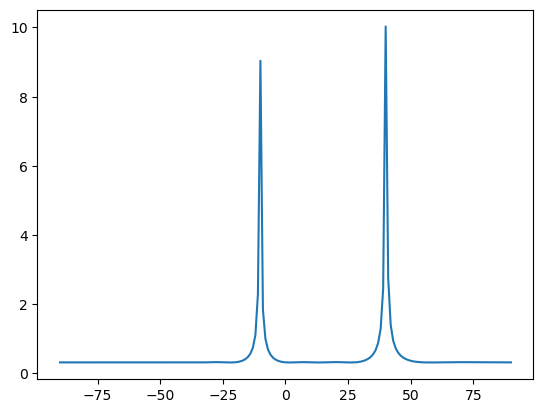

In [23]:
music_spectrum,theta_range,teta_vector,error = music_algorithm1(10,100,100,4)
print(teta_vector)
print(error)
plt.plot(np.degrees(theta_range), music_spectrum,label='old')

[-10  40]
0.0


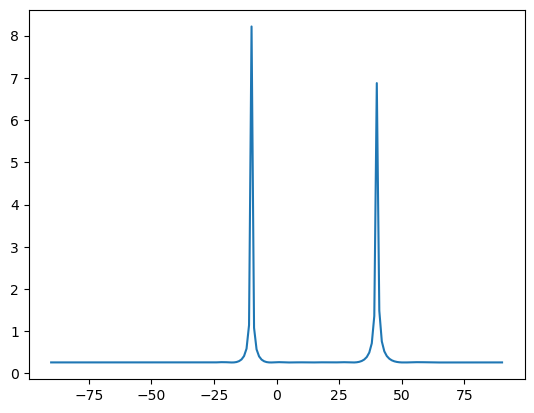

In [26]:
music_spectrum,theta_range,teta_vector,error = music_algorithm2(10,100,100,4)
print(teta_vector)
print(error)
plt.plot(np.degrees(theta_range), music_spectrum,label='old')

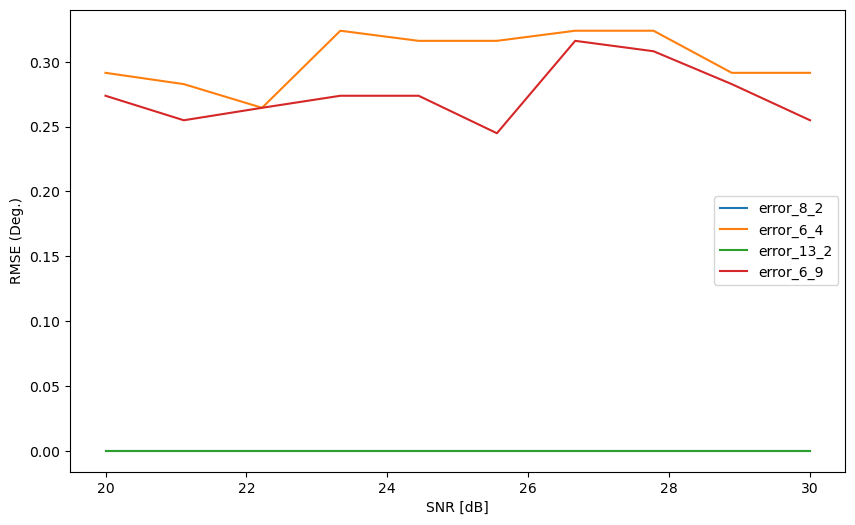

In [36]:
SNR_space = np.linspace(20,30,10)
snap = 100
monte = 100

error_8_2 = [music_algorithm1(SNR_space[i],snap,monte,4,2)[3] for i in range(len(SNR_space))]
error_6_4 = [music_algorithm1(SNR_space[i],snap,monte,4,4)[3] for i in range(len(SNR_space))]

error_13_2 = [music_algorithm2(SNR_space[i],snap,monte,4,2)[3] for i in range(len(SNR_space))]
error_6_9 = [music_algorithm2(SNR_space[i],snap,monte,4,9)[3] for i in range(len(SNR_space))]


fig = plt.figure(figsize=(10, 6))
plt.plot(SNR_space, error_8_2, label="error_8_2")
plt.plot(SNR_space, error_6_4, label="error_6_4")
plt.plot(SNR_space, error_13_2, label="error_13_2")
plt.plot(SNR_space, error_6_9, label="error_6_9")
plt.ylabel("RMSE (Deg.)")
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

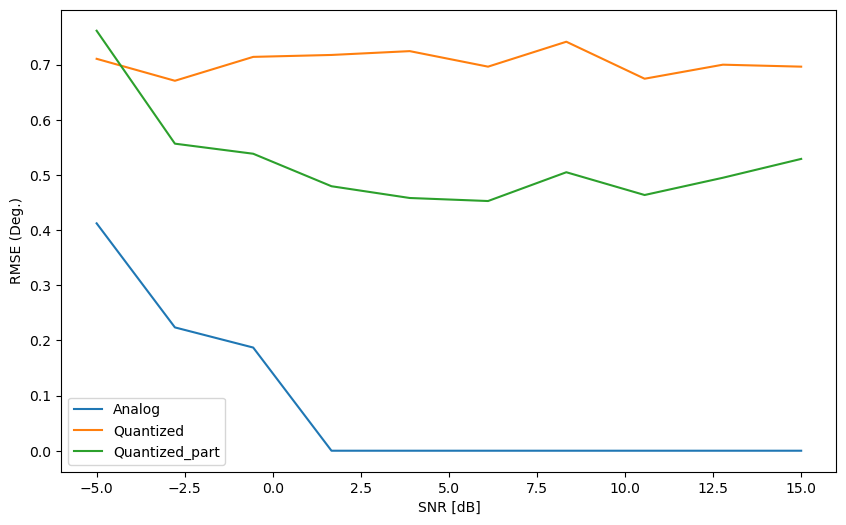

In [9]:
SNR_space = np.linspace(-5,15,10)
snap = 100
monte = 100
error_a = [music_algorithm1(SNR_space[i],snap,monte,0)[3] for i in range(len(SNR_space))]
error_q = [music_algorithm1(SNR_space[i],snap,monte,1)[3] for i in range(len(SNR_space))]
#error_q_sin = [music_algorithm(SNR_space[i],snap,monte,2)[3] for i in range(len(SNR_space))]
# error_q_lin = [music_algorithm(SNR_space[i],snap,monte,3)[3] for i in range(len(SNR_space))]
error_q_part = [music_algorithm1(SNR_space[i],snap,monte,4,int(M1/2))[3] for i in range(len(SNR_space))]


fig = plt.figure(figsize=(10, 6))
plt.plot(SNR_space, error_a, label="Analog")
plt.plot(SNR_space, error_q, label="Quantized")
# plt.plot(SNR_space, error_q_sin, label="Quantized_sin")
# plt.plot(SNR_space, error_q_lin, label="Quantized_lin")
plt.plot(SNR_space, error_q_part, label="Quantized_part")
plt.ylabel("RMSE (Deg.)")
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

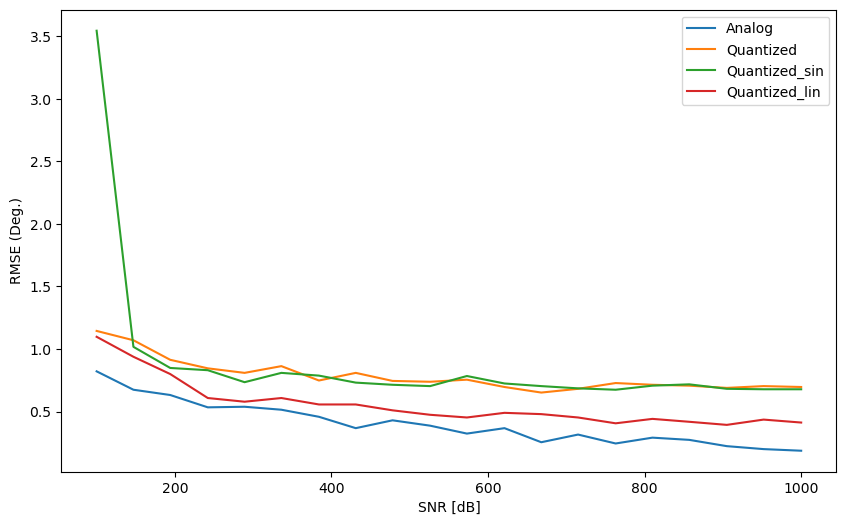

In [10]:
SNR2 = -10
snap_space = np.linspace(100, 1000, 20, dtype=int)
monte2 = 50
error_a2 = [music_algorithm(SNR2,snap_space[i],monte,0)[3] for i in range(len(snap_space))]
error_q2 = [music_algorithm(SNR2,snap_space[i],monte,1)[3] for i in range(len(snap_space))]
error_q_sin2 = [music_algorithm(SNR2,snap_space[i],monte,2)[3] for i in range(len(snap_space))]
error_q_lin2 = [music_algorithm(SNR2,snap_space[i],monte,3)[3] for i in range(len(snap_space))]

fig = plt.figure(figsize=(10, 6))
plt.plot(snap_space, error_a2, label="Analog")
plt.plot(snap_space, error_q2, label="Quantized")
plt.plot(snap_space, error_q_sin2, label="Quantized_sin")
plt.plot(snap_space, error_q_lin2, label="Quantized_lin")
plt.ylabel("RMSE (Deg.)")
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()